In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import numpy as np

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')
# Enable latex in plot
# matplotlib.rcParams['text.usetex'] = True

run_dir = "../models"

In [2]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
0,pretrained_complete,linear_regression,Transformer,,-1,-1,20,12,8,fix_linear_regression_standard


In [3]:
task = "linear_regression"

run_id = "pretrained_complete"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

run_name: fix_linear_regression_standard, id: pretrained_complete


100%|██████████| 15/15 [00:00<00:00, 216201.24it/s]

------------------------
basic_plot: ['Transformer', 'Least Squares', '3-Nearest Neighbors', 'Averaging']


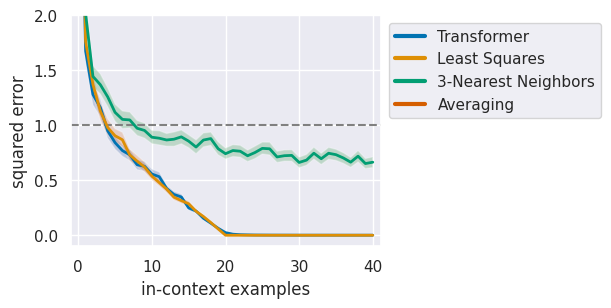

In [4]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [5]:
from samplers import get_data_sampler
from tasks import get_task_sampler

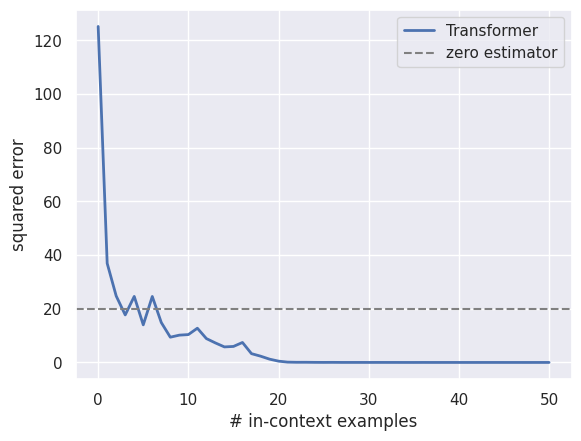

In [8]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size
data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)
with torch.no_grad():
    pred = model(xs, ys)
metric = task.get_metric()
loss = metric(pred, ys).numpy()

baseline = {
    "linear_regression": n_dims,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

### 4.1 Sample Selection / Covariate Shifts

In [9]:
def R_Square_Error(ys, pred):
    y_mean = torch.mean(ys)

    SS_tot = torch.sum((ys - y_mean) ** 2)
    SS_res = torch.sum((ys - pred) ** 2)
    R_square = 1 - SS_res / SS_tot
    return R_square

####  Part 1 - Sample Selection: W1 = 1, w2 = 0

In [10]:
n_batches = 100
prompt_length = 76
# # save xs and ys for the base_line
xs_list = [] 
ys_list = [] 
actual_points_w_1 = [[] for _ in range(prompt_length)]
predicted_points_w_1 = [[] for _ in range(prompt_length)]
# Generate data and perform the experiment
for _ in tqdm(range(n_batches)):

    xs = data_sampler.sample_xs(b_size=batch_size, n_points=prompt_length)
    # 64 x 101 x 20
    xs_list.append(xs)
    ys = task.evaluate(xs)
    # 64 x 101
    ys_list.append(ys)

    with torch.no_grad():
        pred = model(xs, ys)
    for j in range(prompt_length):
        actual_points_w_1[j].extend(ys[:, j])
        predicted_points_w_1[j].extend(pred[:, j])

w_1 = []

for point_idx in range(prompt_length):
    actual = torch.tensor(actual_points_w_1[point_idx])
    predicted = torch.tensor(predicted_points_w_1[point_idx])
    R_square = R_Square_Error(actual, predicted)
    w_1.append(R_square)

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
with open('./data/exp_1_w_1.txt', 'w') as f:
    for value in w_1:
        f.write(f"{value}\n")

####  Part 2 - Covariate Shifts

##### W1 = 0.9, w2 = 0.1

In [12]:
actual_points_w_9 = [[] for _ in range(prompt_length)]
predicted_points_w_9 = [[] for _ in range(prompt_length)]
for _ in tqdm(range(n_batches)):
    xs = data_sampler.sample_xs(b_size=batch_size, n_points=prompt_length, w1=0.9, w2=0.1)
    ys = task.evaluate(xs)

    with torch.no_grad():
        pred = model(xs, ys)
    for j in range(prompt_length):
        actual_points_w_9[j].extend(ys[:, j])
        predicted_points_w_9[j].extend(pred[:, j])
        
w_9 = []

for point_idx in range(prompt_length):
    actual = torch.tensor(actual_points_w_9[point_idx])
    predicted = torch.tensor(predicted_points_w_9[point_idx])
    R_square = R_Square_Error(actual, predicted)
    w_9.append(R_square)



  0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
with open('./data/exp_1_w_9.txt', 'w') as f:
    for value in w_9:
        f.write(f"{value}\n")

##### W1 = 0.7, w2 = 0.3

In [14]:
actual_points_w_7 = [[] for _ in range(prompt_length)]
predicted_points_w_7 = [[] for _ in range(prompt_length)]
for _ in tqdm(range(n_batches)):
    xs = data_sampler.sample_xs(b_size=batch_size, n_points=prompt_length, w1=0.7, w2=0.3)
    ys = task.evaluate(xs)

    with torch.no_grad():
        pred = model(xs, ys)
    for j in range(prompt_length):
        actual_points_w_7[j].extend(ys[:, j])
        predicted_points_w_7[j].extend(pred[:, j])
        

w_7 = []

for point_idx in range(prompt_length):
    actual = torch.tensor(actual_points_w_7[point_idx])
    predicted = torch.tensor(predicted_points_w_7[point_idx])
    R_square = R_Square_Error(actual, predicted)
    w_7.append(R_square)



  0%|          | 0/100 [00:00<?, ?it/s]

In [15]:
with open('./data/exp_1_w_7.txt', 'w') as f:
    for value in w_7:
        f.write(f"{value}\n")

##### W1 = 0.5, w2 = 0.5

In [16]:
actual_points_w_5 = [[] for _ in range(prompt_length)]
predicted_points_w_5 = [[] for _ in range(prompt_length)]
all_errors_w1_5 = []
for _ in tqdm(range(n_batches)):
    xs = data_sampler.sample_xs(b_size=batch_size, n_points=prompt_length, w1=0.5, w2=0.5)
    ys = task.evaluate(xs)

    with torch.no_grad():
        pred = model(xs, ys)
    for j in range(prompt_length):
        actual_points_w_5[j].extend(ys[:, j])
        predicted_points_w_5[j].extend(pred[:, j])
        

w_5 = []

for point_idx in range(prompt_length):
    actual = torch.tensor(actual_points_w_5[point_idx])
    predicted = torch.tensor(predicted_points_w_5[point_idx])
    R_square = R_Square_Error(actual, predicted)
    w_5.append(R_square)



  0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
with open('./data/exp_1_w_5.txt', 'w') as f:
    for value in w_5:
        f.write(f"{value}\n")

##### Baseline

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [19]:
base_line = []
actual_points_base_line = [[] for _ in range(prompt_length)]
predicted_points_base_line = [[] for _ in range(prompt_length)]
for time_idx in tqdm(range(n_batches)):
    xs = xs_list[time_idx]
    ys = ys_list[time_idx]
    for batch_idx in range(batch_size):
    # Get the current batch's data
        for j in range(1, prompt_length):
            X = xs[batch_idx, :j, :] 
            y = ys[batch_idx, :j]  
            
            # Last x value used for prediction
            X_predict = xs[batch_idx, j, :].reshape(1, -1)
            y_true = ys[batch_idx, j]
         
            # Train the model
            linear_model = LinearRegression()
            linear_model.fit(X, y)
        
            y_pred = linear_model.predict(X_predict)
            actual_points_base_line[j].append(y_true)
            predicted_points_base_line[j].append(y_pred[0])
 
base_line.append(0)
for point_idx in range(1, prompt_length):
    actual = torch.tensor(actual_points_base_line[point_idx])
    predicted = torch.tensor(predicted_points_base_line[point_idx])
    R_square = R_Square_Error(actual, predicted)
    base_line.append(R_square)


  0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
with open('./data/base_line.txt', 'w') as f:
    for value in base_line:
        f.write(f"{value}\n")

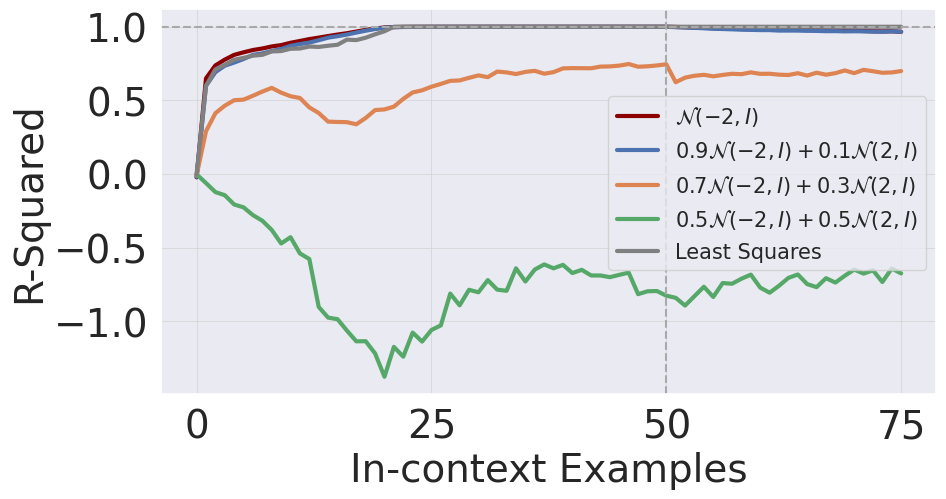

In [23]:

plt.figure(figsize=(10, 5), facecolor='none')
plt.plot(range(prompt_length), w_1, label=r"$\mathcal{N}(-2,I)$", linewidth=3, color="darkred")
plt.plot(range(prompt_length), w_9, label=r"$0.9\mathcal{N}(-2,I) + 0.1\mathcal{N}(2,I)$", linewidth=3)
plt.plot(range(prompt_length), w_7, label=r"$0.7\mathcal{N}(-2,I) + 0.3\mathcal{N}(2,I)$", linewidth=3)
plt.plot(range(prompt_length), w_5, label=r"$0.5\mathcal{N}(-2,I) + 0.5\mathcal{N}(2,I)$", linewidth=3)
plt.plot(range(prompt_length), base_line, label="Least Squares", linewidth=3, color="grey")
x = [0, 25, 50, 75]
plt.xticks(x, fontsize=28)
plt.yticks(fontsize=28)
plt.axhline(1, ls="--", color="darkgrey")
plt.axvline(x=50, color='darkgrey', linestyle='--')  # Grey vertical line
plt.legend(loc='lower right',   bbox_to_anchor=(1.0, 0.295), fontsize=15)
plt.xlabel('In-context Examples', fontsize=28)
plt.ylabel('R-Squared', fontsize=28)
plt.grid(color='lightgray', linestyle='-', linewidth=0.5)
# safe fig
plt.savefig("../output/4_1.pdf", bbox_inches = "tight", transparent=True)
plt.show()